# Analiza zarobków analityków danych i zawodów pokrewnych na świecie z podziałem na stanowiska

[Górski Szymon](https://github.com/SzymonTomasz), [Szura Michał](https://github.com/Malamity) i [Stano Paweł](https://github.com/pstano1)

#### Spis treści:
- [Wstęp](#wstep)
- [Metodologia](#metodologia)
- [Konfiguracja i implementacja](#konfiguracja-i-implementacja)
- [Podział stanowisk](#podzial-stanowisk)
- [Analiza zarobków według państwa](#analiza-zarobków-według-państwa)
- [Analiza zarobków według stanowiska](#analiza-zarobków-według-stanowiska)
- [Porównanie dla podanych danych z wykorzystaniem parytetu siły nabywczej](#porównanie-dla-podanych-danych-z-wykorzystaniem-parytetu-siły-nabywczej)
- [Wnioski](#wnioski)
- [Blibliografia](#bibliografia)
- [Aneksy](#aneksy)

## Wstęp

Analityka danych i pokrewne zawody stały się nieodzowną częścią strategii rozwoju nowoczesnych firm w ostatniej dekadzie. Dzięki zdolności do zbierania, przetwarzania i interpretowania danych, specjaliści w tej dziedzinie pomagają firmom podejmować lepsze decyzje biznesowe i zyskiwać przewagę konkurencyjną. Wzrost znaczenia analizy danych wiąże się również ze wzrostem zarobków specjalistów, co czyni tę profesję atrakcyjną na całym świecie.

Celem tego raportu jest analiza zarobków analityków danych i pokrewnych zawodów na świecie, uwzględniająca różnice między poszczególnymi stanowiskami oraz regionami geograficznymi. 

## Metodologia

### Źródła danych

W niniejszym raporcie wykorzystano dane pochodzące z kilku głównych źródeł:

1. Zbiór danych o zarobkach: Dane dotyczące wynagrodzeń analityków danych i pokrewnych zawodów zostały pozyskane z platformy `kaggle` i zostały przygotowane na podstiwe danych udostępnionych przez platformę `Glassdoor`, która gromadzi informacje na temat wynagrodzeń pracowników na podstawie raportów zgłaszanych przez użytkowników i analizy rynkowej.

2. Tabele Narodowego Banku Polskiego (NBP): Dane dotyczące kursów walut pochodzą z Tabel Narodowego Banku Polskiego, zapewniając jednolitą bazę do porównań zarobków w różnych regionach geograficznych.

3. Dane dotyczące Paritetu Siły Nabywczej (PPP): Informacje na temat parytetu siły nabywczej (PPP) zostały zaczerpnięte z bazy danych udostępnionej na portalu `worldpopulationreview.com`. PPP umożliwia porównanie siły nabywczej zarobków w różnych krajach, uwzględniając różnice w kosztach życia i poziomach cen. Dzięki temu możliwe jest dokładniejsze porównanie realnych zarobków między regionami o odmiennych warunkach ekonomicznych.

### Metody analizy

#### Czyszczenie i normalizacja danych

W klasie `GlassdoorSalary` proces czyszczenia i normalizacji danych jest kluczowym etapem, który zapewnia, że dane są spójne i gotowe do analizy. Proces zaczyna się od załadowania danych z pliku CSV, który jest pobierany z określonego źródła (w tym przypadku kaggle). Dane są następnie oczyszczane z pustych wartości oraz wartości reprezentujących brak danych (np. 'NA' czy '-'). Kolejnym krokiem jest przetworzenie kolumn zawierających wartości pieniężne. Funkcja process_data przekształca wartości zapisane w formacie takim jak '$1M' lub '$1K' na liczby rzeczywiste. Przykładowo, '$1M' zostanie przekształcone na 1,000,000. Dodatkowo, waluty są konwertowane na standardowe kody walut, co umożliwia ich późniejszą konwersję do wspólnej waluty przy użyciu odpowiednich kursów wymiany.

#### Miary tendecji centralnej

Klasa GlassdoorSalary oferuje różnorodne metody obliczania miar tendencji centralnej, które są niezbędne do analizy danych płacowych.

- Średnia: Metoda `calculate_mean` oblicza średnią arytmetyczną dla określonej kolumny, co jest przydatne do zrozumienia ogólnego poziomu wynagrodzeń.

- Mediana: Mediana, obliczana za pomocą `calculate_median`, jest szczególnie przydatna w przypadku rozkładów płac, które mogą być skośne, ponieważ nie jest ona tak podatna na wartości odstające jak średnia.

- Moda: Moda, obliczana metodą `calculate_mode`, pokazuje najczęściej występującą wartość w zbiorze danych, co może być użyteczne w identyfikacji typowych wynagrodzeń.

- Odchylenie standardowe: Metoda `calculate_stdv` pozwala obliczyć odchylenie standardowe, które mierzy, jak bardzo wartości w zbiorze danych różnią się od średniej, dając wgląd w zmienność płac.

Ponadto dla użytkownika dostępna jest funkcja pozwalająca na porównanie obecnego kraju zamieszkania oraz obejmowanego stanowiska z wybranym krajem - wykorzystując parytet siły nabywczej pieniądza pozwala ona na miarodajny wgląd w potencjalną sytuację materialną po zmianie kraju zamieszkania.

#### Narzędzia

##### Biblioteki

In [407]:
import requests as re
import json
import base64
import zipfile
import pandas as pd
import csv
import unicodedata
import numpy as np
from io import BytesIO, StringIO
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:,.2f}'.format


#### Klasy i funkcje 

In [408]:
from typing import Callable

class GlassdoorSalary:
  base_url = "https://www.kaggle.com/api/v1"
  owner = "imbishal7"
  dataset_name = "glassdoor-salary"
  filename = "salaries.csv"
  version = 1

  def __init__(self, username: str, key: str, currency_codes: dict) -> None:
    self.username = username
    self.key = key
    self.currency_symbols = currency_codes

    credentials = base64.b64encode(bytes(f"{self.username}:{self.key}", "ISO-8859-1")).decode("ascii")
    self.headers = {
      "Authorization": f"Basic {credentials}"
    }
    self.dataset = pd.DataFrame()

  def load_dataset(self) -> None:
    '''
      Loads dataset from specified link, unzips it & clears the empty cells
    '''
    url = f'{self.base_url}/datasets/download/{self.owner}/{self.dataset_name}?datasetVersionNumber={self.version}'
    res: re.Response 
    try:
      res = re.get(url, headers=self.headers, stream=True)
    except Exception as e:
      print(e)
      return 
    
    try:
      zf = zipfile.ZipFile(BytesIO(res.content))
      with zf.open(self.filename) as f:
        content = f.read().decode('utf-8')
        f = StringIO(content)
        set = []
        spamreader = csv.reader(f, delimiter='\t', quotechar=u'\xa0')
        for row in spamreader:
            row = [unicodedata.normalize('NFC',i)  for i in row]
            set.append(row)

        self.dataset = pd.DataFrame(columns = set[0][:-1], data = set[1:])
        self.dataset = self.dataset[~self.dataset.isin(['NA', '-']).any(axis=1)]
        self.dataset = self.dataset.dropna()
    except Exception as e:
        print(e)
        return
  
  def process_data(self) -> None:
    '''
      Proccesses the data columns containing money values (median, high, low)
      example: a monetary field of high bound of pay range 
      may be written as $1M, this function clears this mess up
      by writting $ to `currency` as `USD` column & changing 1M into 
      proper numeric value of 1000000
    '''
    def convert_to_proper_number(value):
      multiplier = 1
      if 'K' in value:
          multiplier = 1000
      elif 'M' in value:
          multiplier = 1000000
      value = value.replace('K', '')
      value = value.replace('M', '')
      
      return float(value) * multiplier
  
    currency_codes = self.dataset['median'].str.extract(r'^(\w+)', expand=False)
      
    self.dataset['currency'] = currency_codes.map(self.currency_symbols)
    self.dataset['currency'] = self.dataset['currency'].fillna(currency_codes)
  
    symbols = self.dataset.loc[self.dataset['currency'].isna(), 'median'].str.extract(r'([^\d\.\-KM])', expand=False).fillna('')
    self.dataset['currency'] = self.dataset['currency'].fillna(symbols.map(self.currency_symbols))
        
    self.dataset['currency'] = self.dataset['currency'].fillna(symbols)
    
    self.dataset['median'] = self.dataset['median'].str.replace(r'[^\d\.\-]', '', regex=True).astype(float)
    self.dataset['low'] = self.dataset['low'].str.replace(r'[^\d\.\-KM]', '', regex=True).apply(convert_to_proper_number)
    self.dataset['high'] = self.dataset['high'].str.replace(r'[^\d\.\-KM]', '', regex=True).apply(convert_to_proper_number)

    self.dataset = self.remove_outliers('median', 'country')

  def get_dataset(self) -> pd.DataFrame:
    return self.dataset
  
  def select_by_hourly_rate(self) -> pd.DataFrame:
    def convert_to_hr_rate(value, unit):
      conversion_factors = {
        '/yr': 12 * 160,
        '/mo': 160,
        '/hr': 1
      }

      return value / conversion_factors[unit]
    
    for col in ['median', 'low', 'high']:
      self.dataset[col] = self.dataset.apply(lambda row: convert_to_hr_rate(row[col], row['unit']), axis=1)
    self.dataset['unit'] = '/hr'

    return self.get_dataset()
  
  def select_by_monthly_rate(self) -> pd.DataFrame:
    def convert_to_mo_rate(value, unit):
      conversion_factors = {
        '/yr': (1/12),
        '/mo': 1,
        '/hr': 160
      }

      return value * conversion_factors[unit]
    
    for col in ['median', 'low', 'high']:
      self.dataset[col] = self.dataset.apply(lambda row: convert_to_mo_rate(row[col], row['unit']), axis=1)
    self.dataset['unit'] = '/mo'

    return self.get_dataset()
  
  def select_by_yearly_rate(self) -> pd.DataFrame:
    def convert_to_mo_rate(value, unit):
      conversion_factors = {
        '/yr': 1,
        '/mo': 12,
        '/hr': 160*12
      }

      return value * conversion_factors[unit]
    
    for col in ['median', 'low', 'high']:
      self.dataset[col] = self.dataset.apply(lambda row: convert_to_mo_rate(row[col], row['unit']), axis=1)
    self.dataset['unit'] = '/yr'

    return self.get_dataset()
  
  def to_common_currency(self, to_currency: str, get_exchange_rate: Callable[[str, str], float]) -> pd.DataFrame:
    '''
      Converts salary data to a specified common currency for unified analysis
    '''
    def convert_value(row, column):
      from_currency = row['currency']
      value = row[column]
      if from_currency == to_currency:
        return value
      exchange_rate = get_exchange_rate(from_currency, to_currency)
      
      return value * exchange_rate
    
    self.dataset[to_currency + '_median'] = self.dataset.apply(lambda row: convert_value(row, 'median'), axis=1)
    self.dataset[to_currency + '_low'] = self.dataset.apply(lambda row: convert_value(row, 'low'), axis=1)
    self.dataset[to_currency + '_high'] = self.dataset.apply(lambda row: convert_value(row, 'high'), axis=1)
    
    self.dataset = self.remove_outliers(f'{to_currency}_median', 'company')

    return self.get_dataset()
  
  def remove_outliers(self, column: str, group_by: str) -> pd.DataFrame:
    def filter_group(group):
      Q1 = group[column].quantile(0.25)
      Q3 = group[column].quantile(0.75)

      IQR = Q3 - Q1

      lower_bound = Q1 - 1.5 * IQR
      upper_bound = Q3 + 1.5 * IQR

      return group[(group[column] >= lower_bound) & (group[column] <= upper_bound)]
    
    return self.dataset.groupby(group_by).apply(filter_group).reset_index(drop=True)

  def calculate_mean(self, column: str) -> float:
    return self.dataset[column].mean()
  
  def calculate_grouped_mean(self, group_by: str, column: str) -> pd.DataFrame:
    return self.dataset.groupby(group_by)[column].mean().reset_index()
  
  def get_unique_values(self, column_name: str):
    return self.dataset[column_name].unique()
  
  def calculate_mode(self, column: str):
    return self.dataset[column].mode()
  
  def calculate_grouped_mode(self, group_by: str, column: str) -> pd.DataFrame:
    return self.dataset.groupby(group_by)[column].apply(lambda x: x.mode()).reset_index().copy()
  
  def calculate_median(self, column: str) -> float:
    return self.dataset[column].median()
  
  def calculate_grouped_median(self, group_by: str, column: str) -> pd.DataFrame:
    return self.dataset.groupby(group_by)[column].median().reset_index()
  
  def calculate_stdv(self, column: str) -> pd.DataFrame:
    return self.dataset[column].std()
  
  def calculate_grouped_stdv(self, group_by: str, column: str) -> pd.DataFrame:
    return self.dataset.groupby(group_by)[column].std().reset_index()

In [409]:
class ExchangeProvider:
    currencies = {}

    def __init__(self, tables_wanted, currency_symbols):
        self.symbol_map = currency_symbols
        for table_name in tables_wanted:
            json_nbp_curr = re.get(f"http://api.nbp.pl/api/exchangerates/tables/{table_name}/last/1/?format=json").json()
            for rate in json_nbp_curr[0]['rates']:
                self.currencies[rate['code']] = rate['mid']

    def get_rate(self, from_currency, to_currency):
        if from_currency == to_currency:
            return 1

        from_rate = 0
        to_rate = 0

        if to_currency == "PLN":
            return  self.currencies[from_currency]
        elif from_currency == "PLN":
            return 1 / self.currencies[to_currency]
        else:
            try:
                from_rate = self.currencies[from_currency]
            except Exception as e:
                print(f"{e}")
                return -1
            
            try:
                to_rate = self.currencies[to_currency]
            except Exception as e:
                print(f"{e}")
                return -1
            
            return from_rate / to_rate
        
    def exchange_symbol_for_code(self, symbol: str) -> str:
        return self.symbol_map[symbol]


In [410]:
def compared_salary(base_country, compared_country, job_role, grouped_original_data, ppp_data):
    def comment(value_ppp):
        return  f"Your purchasing power would be  {abs(round(value_ppp,2))} % {'lower' if value_ppp < 0 else 'higher'}."

    base_set = grouped_original_data.query(f'role == "{job_role}"  and  (country == "{base_country}" )')
    compared_set = grouped_original_data.query(f'role == "{job_role}" and country == "{compared_country}"')
    
    base_set = base_set.merge(ppp_data, how='left', left_on='country', right_on = 'country')
    base_set['adjusted_salary_ppp'] = base_set.apply(lambda row: row['median'] / row['PppINT']  , axis=1) 

    compared_set = compared_set.merge(ppp_data, how='left', left_on='country', right_on = 'country')
    compared_set['adjusted_salary_ppp'] = compared_set.apply(lambda row: row['median'] / row['PppINT']  , axis=1) 

    return_set = base_set.merge(compared_set, how='cross', suffixes=('_base', '_comp'))
    return_set['Adjusted percentage by PPP'] = return_set.apply(lambda row: (((row['adjusted_salary_ppp_comp'] -  row['adjusted_salary_ppp_base'] )/row['adjusted_salary_ppp_base'])* 100  ), axis = 1)

    return_set = return_set[['country_base', 'country_comp', 'role_comp', 'Adjusted percentage by PPP']]
    return_set.rename(columns={"country_base": "Country based", "country_comp": "Country compared",
                                'role_comp': 'Compared role', 'Adjusted percentage by PPP': 'Adjusted % by PPP'}, inplace=True)
    return_set['Comment'] = return_set.apply(lambda row: comment(row['Adjusted % by PPP']), axis=1)


    return return_set

## Konfiguracja i implementacja

### Konfiguracja

In [411]:
common_currency = "EUR"
common_work_unit = "yr" # "yr" | "mo" | "hr"

# Konfiguracja dla porównań z parytetem siły nabywaczej
country_of_origin = "Poland"
desired_destination_country = "United States"
my_role = "Business Intelligence Developer"

### Implementacja

In [412]:
with open('./currencies.json', encoding = 'utf8') as f:
    currencies = json.load(f)

exchange_provider = ExchangeProvider(["a", "b"], currencies)

In [413]:
with open('./kaggle.json') as f: 
    credentials = json.load(f)

a = GlassdoorSalary(credentials['username'], credentials['key'], currencies)
a.load_dataset()
a.process_data()
test = a.get_dataset()
print("Sukces")

/var/folders/wy/8f4lwcwd4pz4p8qrqmglgpjr0000gn/T/ipykernel_68692/1106097373.py:170: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return self.dataset.groupby(group_by).apply(filter_group).reset_index(drop=True)


Sukces


In [414]:
if common_work_unit == "yr":
    a.select_by_yearly_rate()
elif common_work_unit == "mo":
    a.select_by_monthly_rate()
else:
    a.select_by_hourly_rate()
print("Sukces")

Sukces


In [415]:
a.to_common_currency('EUR', exchange_provider.get_rate)
print("Sukces")

Sukces


/var/folders/wy/8f4lwcwd4pz4p8qrqmglgpjr0000gn/T/ipykernel_68692/1106097373.py:170: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return self.dataset.groupby(group_by).apply(filter_group).reset_index(drop=True)


## Podział stanowisk

In [416]:
pd.DataFrame(a.get_unique_values('role'), columns=['Roles'])

,Roles
0,Data Scientist
1,Data Engineer
2,Senior Data Analyst
3,Senior Data Scientist
4,Database Administrator
5,Business Analyst
6,Business Intelligence Developer
7,Data Analyst


#### Data Scientist

Data scientist sprawdzają, które pytania wymagają odpowiedzi i gdzie znaleźć powiązane dane. Posiadają wiedzę biznesową i umiejętności analityczne, a także zdolność do wydobywania, czyszczenia i prezentowania danych. Data scientists wykorzystują również techniki uczenia maszynowego do modelowania informacji i skutecznej interpretacji wyników.

#### Data Engineer

Data engineer zarządzają wykładniczo rosnącymi i szybko zmieniającymi się danymi. Koncentrują się na opracowywaniu, wdrażaniu, zarządzaniu i optymalizacji potoków danych i infrastruktury w celu przekształcania i przesyłania danych.

#### Data Analyst

Analitycy danych wypełniają lukę między analitykami danych a analitykami biznesowymi. Dostarczane są im pytania, na które organizacja potrzebuje odpowiedzi, a następnie organizują i analizują dane w celu znalezienia wyników zgodnych z wysokopoziomową strategią biznesową. Analitycy danych są odpowiedzialni za przekładanie analiz technicznych na jakościowe elementy działań i skuteczne przekazywanie swoich ustaleń różnym interesariuszom.


#### Database Administrator

Administrator bazy danych (DBA) zarządza komputerowymi bazami danych. Rola ta może obejmować planowanie pojemności, instalację, konfigurację, projektowanie baz danych, migrację, monitorowanie wydajności, bezpieczeństwo, rozwiązywanie problemów, a także tworzenie kopii zapasowych i odzyskiwanie danych.


#### Senior Data Analyst

Senior data analyst to profesjonaliści z bogatym doświadczeniem zawodowym, którzy zajmują się analizą dużych zbiorów danych. Cała praca starszego analityka danych jest związana z dużymi zbiorami danych. Specjaliści analizują, sortują i interpretują je w formie raportów oraz przygotowują dokumentację.

#### Senior Data Scientist

Senior data scientist odkrywają spostrzeżenia poprzez analizę danych w celu wspierania rozwoju biznesu i strategii przedsiębiorstwa. Mają podobne obowiązki do junior data scientist, ale są bardziej zaangażowani w zarządzanie zespołem, a także mają większy autorytet w długoterminowych decyzjach i projektach opartych na danych.

#### Business Analyst

Business analyst (BA) są odpowiedzialni za wypełnianie luki między IT a biznesem przy użyciu analizy danych do oceny procesów, określania wymagań i dostarczania opartych na danych zaleceń i raportów dla kadry kierowniczej i interesariuszy.

#### Business Intelligence Developer

Business Intelligence Developer to inżynier, który używa oprogramowania Business Intelligence do interpretowania i wyświetlania danych dla organizacji. Często tworzą narzędzia lub rozwiązują bieżące metody w celu usprawnienia procesu badawczego firmy.

## Analiza zarobków według państwa

### Zgrupowane średnie zarobki według państwa w wartościach bezwględnych sprowadzone do wspólnej waluty

In [417]:
grouped_mean_data = a.calculate_grouped_mean('country', f'{common_currency}_median')
grouped_median_data = a.calculate_grouped_median('country', f'{common_currency}_median')

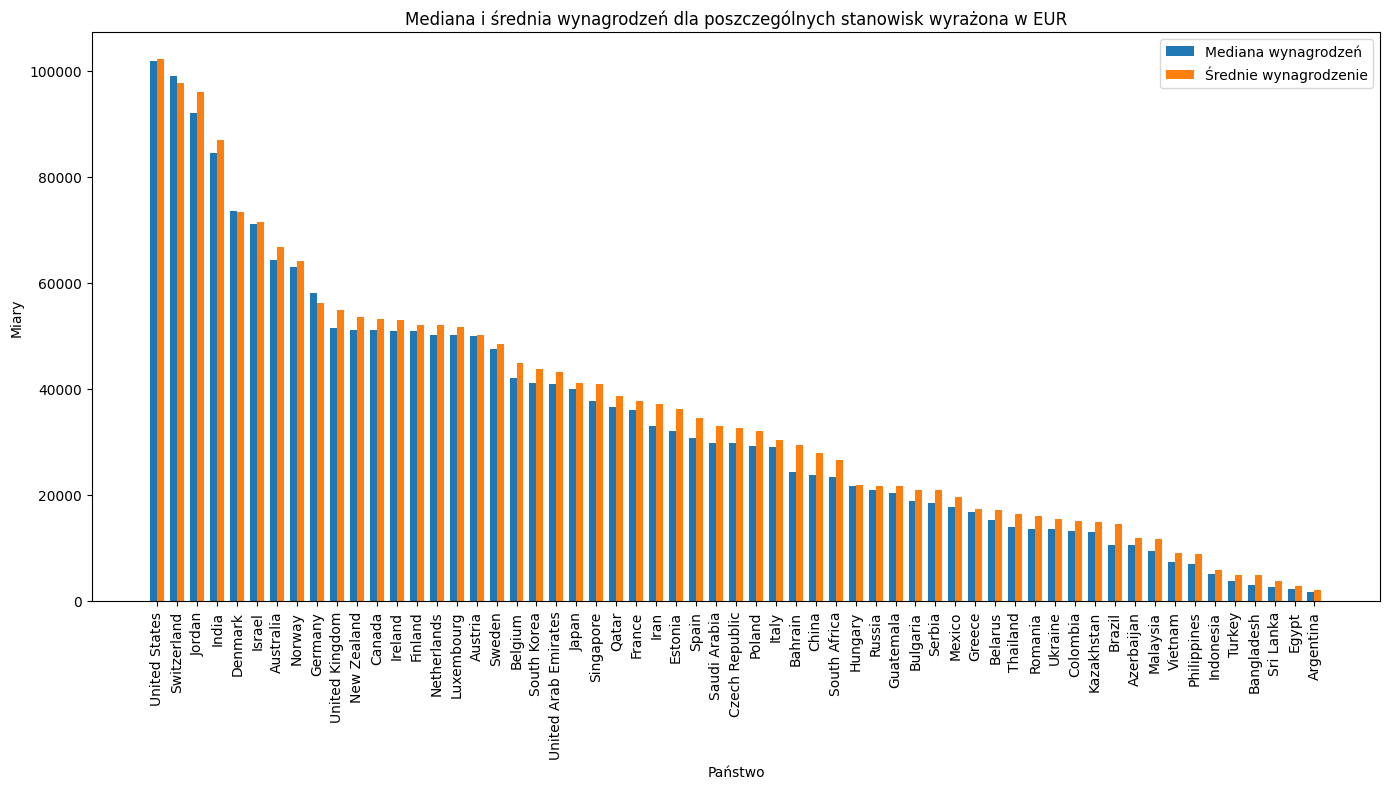

In [418]:
plt.figure(figsize=(14, 8))
grouped_mean_data = grouped_mean_data.sort_values(by=f'{common_currency}_median', ascending=False)
grouped_median_data = grouped_median_data.sort_values(by=f'{common_currency}_median', ascending=False)

bar_width = 0.35
positions = np.arange(len(grouped_mean_data['country']))

plt.bar(positions - bar_width/2, grouped_median_data[f'{common_currency}_median'], width=bar_width, label="Mediana wynagrodzeń")
plt.bar(positions + bar_width/2, grouped_mean_data[f'{common_currency}_median'], width=bar_width, label="Średnie wynagrodzenie")
plt.xlabel('Państwo')
plt.ylabel('Miary')
plt.title(f'Mediana i średnia wynagrodzeń dla poszczególnych stanowisk wyrażona w {common_currency}')
plt.xticks(positions, grouped_mean_data['country'], rotation=90)
plt.tight_layout()
plt.tight_layout()
plt.legend()
plt.show()

### 10 krajów według zarobków w szeroko pojętej analizie danych

In [419]:
grouped_mean_data.head(10)

,country,EUR_median
57,United States,"102,274.08"
51,Switzerland,"97,784.53"
30,Jordan,"96,039.82"
23,India,"86,918.79"
14,Denmark,"73,380.37"
27,Israel,"71,453.61"
1,Australia,"66,771.16"
37,Norway,"64,181.23"
19,Germany,"56,251.33"
56,United Kingdom,"54,959.50"


## Analiza zarobków według stanowiska

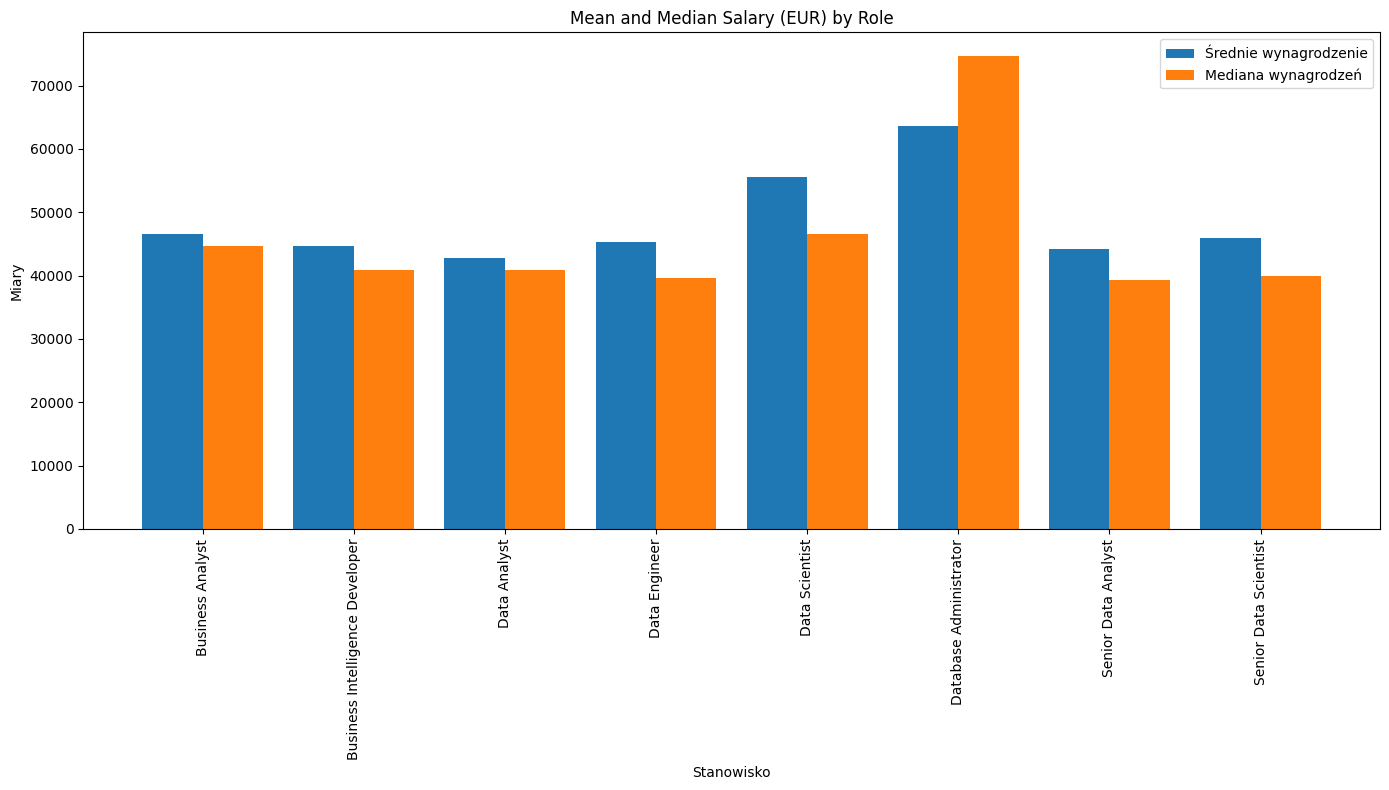

In [420]:
grouped_mean_data = a.calculate_grouped_mean('role', f'{common_currency}_median')
grouped_median_data = a.calculate_grouped_median('role', f'{common_currency}_median')
roles = np.array(grouped_mean_data['role'])

bar_width = 0.4
positions = np.arange(len(roles))

plt.figure(figsize=(14, 8))
plt.bar(positions - bar_width/2, grouped_mean_data[f'{common_currency}_median'], width=bar_width, label='Średnie wynagrodzenie')
plt.bar(positions + bar_width/2, grouped_median_data[f'{common_currency}_median'], width=bar_width, label='Mediana wynagrodzeń')
plt.xlabel('Stanowisko')
plt.ylabel('Miary')
plt.title(f'Mean and Median Salary ({common_currency}) by Role')
plt.xticks(positions, roles, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


### Stanowiska posortowane według wysokości wynagrodzenia

In [421]:
best_by_job = a.calculate_grouped_mean('role', f'{common_currency}_median')
best_by_job = best_by_job.sort_values(by=f'{common_currency}_median', ascending=False)
best_by_job.head(10)

,role,EUR_median
5,Database Administrator,"63,666.34"
4,Data Scientist,"55,602.56"
0,Business Analyst,"46,601.83"
7,Senior Data Scientist,"45,977.83"
3,Data Engineer,"45,363.61"
1,Business Intelligence Developer,"44,607.72"
6,Senior Data Analyst,"44,236.09"
2,Data Analyst,"42,831.49"


### 10 firm z najwyższymi wynagrodzeniami

In [422]:
text = a.get_dataset()
best_by_company = a.calculate_grouped_mean('company', f'{common_currency}_median')
best_by_company = best_by_company.sort_values(by=f'{common_currency}_median', ascending=False)
best_by_company.head(10)

,company,EUR_median
45472,OMC Group,"1,253,550.89"
21267,Elwood Technologies,"1,017,091.93"
38374,M/C/C,"795,984.99"
70823,Zestard Technologies,"708,647.75"
774,ADDOSSER Microfinance Bank,"708,605.23"
70057,Xinfu,"566,643.23"
12217,CapitalVia,"550,627.15"
30141,House of Travel,"545,089.83"
27061,Government Legal Department,"537,686.73"
40898,Metro Asphalt,"517,394.82"


## Porównanie dla podanych danych z wykorzystaniem parytetu siły nabywczej

In [423]:
ppp_data = pd.read_csv('./purchasing-power-parity-by-country-2024.csv')
ppp_data = ppp_data[['country', 'PppINT']]

In [424]:
grouped_original_data = a.calculate_grouped_mean(['country', 'role'], 'median').copy()

In [425]:
compared_salary('Poland', 'United Kingdom', 'Business Intelligence Developer', grouped_original_data, ppp_data)

,Country based,Country compared,Compared role,Adjusted % by PPP,Comment
0,Poland,United Kingdom,Business Intelligence Developer,-17.88,Your purchasing power would be 17.88 % lower.


In [426]:
grouped_original_data_2 = grouped_original_data.merge(ppp_data, how='inner', left_on='country', right_on = 'country')

grouped_original_data_2['Adjusted salary PPP'] = grouped_original_data_2.apply(lambda row:  row['median'] / row['PppINT']  , axis=1)

poland_set = grouped_original_data_2.query(f'country == "{country_of_origin}"')

poland_set = poland_set[['Adjusted salary PPP', 'country', 'role']]
poland_set.rename(columns ={'Adjusted salary PPP' : f'Adjusted salary {country_of_origin}'}, inplace=True)

grouped_original_data_2 = grouped_original_data_2.merge(poland_set, how = 'inner', left_on= 'role', right_on='role')


grouped_original_data_2['Difference in adjusted salary'] = grouped_original_data_2.apply(lambda row: row['Adjusted salary PPP'] - row['Adjusted salary Poland']  , axis=1 )


comparison_set = grouped_original_data_2[['country_x', 'role', 'median', 'Adjusted salary PPP', f'Adjusted salary {country_of_origin}', 'country_y', 'Difference in adjusted salary']].copy()
comparison_set.rename(columns = {'country_x': 'Country','role' : 'Role', 'median': 'Local median', 'Adjusted salary PPP' : 'Local adjusted salary PPP','country_y': 'Compared country'}, inplace=True)

comparison_set.query(f'Country == "{desired_destination_country}" and Role == "{my_role}"')


#                 __
#                |  |
#-------------__ |  |------
#            |  ||  |
#            |  ||  |

,Country,Role,Local median,Local adjusted salary PPP,Adjusted salary Poland,Compared country,Difference in adjusted salary
455,United States,Business Intelligence Developer,"106,698.46","106,698.46","77,285.21",Poland,"29,413.26"


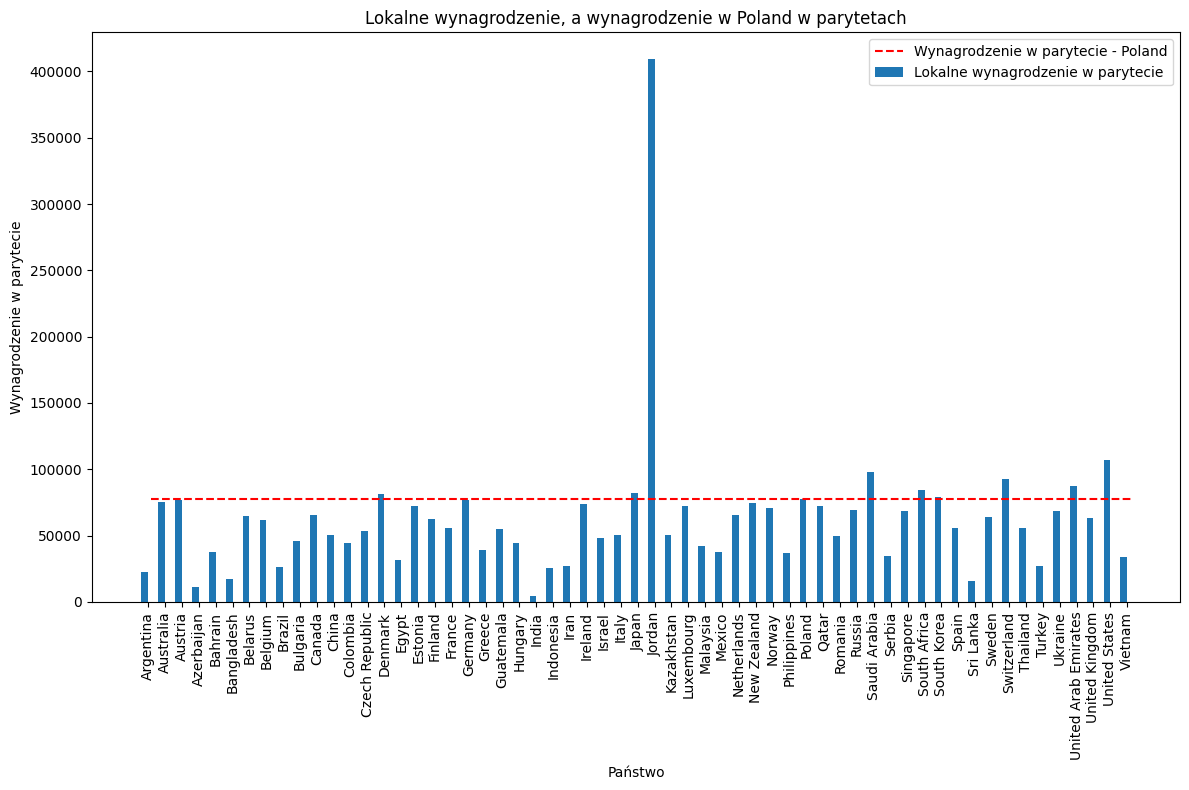

In [427]:
comparison_chart_set = comparison_set.query(f'Role == "{my_role}"').copy()
comparison_chart_set = comparison_chart_set[['Local adjusted salary PPP',f'Adjusted salary {country_of_origin}','Country']]

countries = np.array(comparison_chart_set['Country'])

bar_width = 0.4
positions = np.arange(len(countries))

plt.figure(figsize=(12, 8))
plt.bar(positions - bar_width/2, comparison_chart_set[f'Local adjusted salary PPP'], width=bar_width, label='Lokalne wynagrodzenie w parytecie')
plt.plot(positions + bar_width/2, comparison_chart_set[f'Adjusted salary {country_of_origin}'], linestyle='--', color='red', label=f'Wynagrodzenie w parytecie - {country_of_origin}')

plt.ylabel(f'Wynagrodzenie w parytecie')
plt.xlabel(f'Państwo')
plt.title(f'Lokalne wynagrodzenie, a wynagrodzenie w {country_of_origin} w parytetach')
plt.xticks(positions, countries, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


## Wnioski

Główne wnioski, które nasuwają się po analizie posiadanych danych:

1. Zróżnicowanie geograficzne: Zarobki znacznie różnią się w zależności od kraju, z najwyższymi średnimi wynagrodzeniami w USA i Szwajcarii.
2. Różnice między stanowiskami: Wyższe stanowiska jak Database Administrator czy Data Scientist oferują lepsze wynagrodzenia niż podstawowe role analityczne.
3. Wpływ parytetu siły nabywczej (PPP): Wysokie zarobki w niektórych krajach nie zawsze równają się wyższej sile nabywczej ze względu na koszty życia.
4. Różnice między firmami: Zarobki mogą się znacznie różnić w zależności od firmy, co sugeruje, że negocjowanie wynagrodzenia jest kluczowe.
5. Globalne perspektywy dla specjalistów: Rozwój kariery międzynarodowej jest możliwy, ale decyzje o przeprowadzce warto opierać na analizie zarobków i kosztów życia.

Analiza ta pokazuje, że branża danych oferuje szerokie możliwości, ale wybory zawodowe i lokalizacyjne powinny być podejmowane z uwagą na różne czynniki ekonomiczne.

## Bibliografia

- https://www.kaggle.com/datasets/imbishal7/glassdoor-salary
- https://nbp.pl/statystyka-i-sprawozdawczosc/kursy/
- https://worldpopulationreview.com/country-rankings/purchasing-power-parity-by-country
- https://ischoolonline.berkeley.edu/data-science/what-is-data-science/
- https://en.wikipedia.org/wiki/Database_administrator
- https://anywhere.epam.com/en/senior-data-analyst-job-description
- https://builtin.com/learn/careers/senior-data-scientist
- https://www.cio.com/article/276798/what-is-a-business-analyst-a-key-role-for-business-it-efficiencywhat-is-a-business-analyst-a-key-role-for-business-it-efficiency.html
- https://www.indeed.com/career-advice/finding-a-job/business-intelligence-developer

## Aneksy

In [428]:
clean_dataset = GlassdoorSalary(credentials['username'], credentials['key'], currencies)
clean_dataset.load_dataset()
clean_dataset.get_dataset().head(5)

,role,country,company,company_rating,job_title,median,low,high,unit
0,Data Scientist,Japan,CTW,2.9,Data Scientist,"¥1,500,000",¥1M,¥18M,/yr
1,Data Scientist,Japan,FUJIFILM,3.7,Data Scientist,"¥5,000,000",¥5M,¥7M,/yr
3,Data Scientist,Japan,Data4Cʼs,3,Data Scientist,"¥350,000",¥300K,¥402K,/mo
4,Data Scientist,Japan,Deloitte,4,Data Scientist,"¥6,250,000",¥5M,¥8M,/yr
5,Data Scientist,Japan,Indeed,4.1,Data Scientist,"¥20,500,000",¥20M,¥21M,/yr


In [429]:
clean_dataset.process_data()
clean_dataset.get_dataset().head(5)

/var/folders/wy/8f4lwcwd4pz4p8qrqmglgpjr0000gn/T/ipykernel_68692/1106097373.py:170: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return self.dataset.groupby(group_by).apply(filter_group).reset_index(drop=True)


,role,country,company,company_rating,job_title,median,low,high,unit,currency
0,Data Scientist,Argentina,NEORIS,4.1,Data Scientist,"135,275.00","130,000.00","141,000.00",/mo,ARS
1,Data Scientist,Argentina,Banco Supervielle,3.7,Data Scientist,"200,004.00","193,000.00","207,000.00",/mo,ARS
2,Data Scientist,Argentina,Baufest,4.2,Data Scientist,"88,726.00","85,000.00","93,000.00",/mo,ARS
3,Data Scientist,Argentina,Jampp,4.3,Data Scientist,"150,000.00","100,000.00","228,000.00",/mo,ARS
4,Data Scientist,Argentina,freelance,4.3,Data Scientist,"149,630.00","144,000.00","155,000.00",/mo,ARS


In [430]:
clean_dataset.select_by_yearly_rate().head(5)

,role,country,company,company_rating,job_title,median,low,high,unit,currency
0,Data Scientist,Argentina,NEORIS,4.1,Data Scientist,"1,623,300.00","1,560,000.00","1,692,000.00",/yr,ARS
1,Data Scientist,Argentina,Banco Supervielle,3.7,Data Scientist,"2,400,048.00","2,316,000.00","2,484,000.00",/yr,ARS
2,Data Scientist,Argentina,Baufest,4.2,Data Scientist,"1,064,712.00","1,020,000.00","1,116,000.00",/yr,ARS
3,Data Scientist,Argentina,Jampp,4.3,Data Scientist,"1,800,000.00","1,200,000.00","2,736,000.00",/yr,ARS
4,Data Scientist,Argentina,freelance,4.3,Data Scientist,"1,795,560.00","1,728,000.00","1,860,000.00",/yr,ARS


In [431]:
clean_dataset.to_common_currency(common_currency, exchange_provider.get_rate)

/var/folders/wy/8f4lwcwd4pz4p8qrqmglgpjr0000gn/T/ipykernel_68692/1106097373.py:170: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return self.dataset.groupby(group_by).apply(filter_group).reset_index(drop=True)


,role,country,company,company_rating,job_title,median,low,high,unit,currency,EUR_median,EUR_low,EUR_high
0,Data Scientist,Brazil,"""Centro Paula Souza (ETEC, FATEC, SDECTI)""",3.9,Cientista De Dados,"30,108.00","24,000.00","36,000.00",/yr,BRL,"5,116.20","4,078.27","6,117.41"
1,Data Engineer,Brazil,"""Centro Paula Souza (ETEC, FATEC, SDECTI)""",3.9,Cientista De Dados,"30,024.00","24,000.00","36,000.00",/yr,BRL,"5,101.92","4,078.27","6,117.41"
2,Senior Data Analyst,Brazil,"""Centro Paula Souza (ETEC, FATEC, SDECTI)""",3.9,Cientista De Dados,"29,916.00","24,000.00","36,000.00",/yr,BRL,"5,083.57","4,078.27","6,117.41"
3,Senior Data Scientist,Brazil,"""Centro Paula Souza (ETEC, FATEC, SDECTI)""",3.9,Cientista De Dados,"29,916.00","24,000.00","36,000.00",/yr,BRL,"5,083.57","4,078.27","6,117.41"
4,Database Administrator,Brazil,"""Grupo Máquina de Vendas (Insinuante, Ricardo ...",3.3,Senior Database Administrator (DBA),"165,144.00","156,000.00","168,000.00",/yr,BRL,"28,062.61","26,508.79","28,547.92"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
345300,Senior Data Analyst,France,￼Data Impact,3.5,Data Scientist Intern,"15,540.00","12,000.00","12,000.00",/yr,EUR,"15,540.00","12,000.00","12,000.00"
345301,Senior Data Scientist,France,￼Data Impact,3.5,Data Scientist,"41,501.00","41,000.00","42,000.00",/yr,EUR,"41,501.00","41,000.00","42,000.00"
345302,Senior Data Scientist,France,￼Data Impact,3.5,Data Scientist,"11,964.00","11,544.00","12,000.00",/yr,EUR,"11,964.00","11,544.00","12,000.00"
345303,Senior Data Scientist,France,￼Data Impact,3.5,Data Scientist Intern,"15,636.00","12,000.00","12,000.00",/yr,EUR,"15,636.00","12,000.00","12,000.00"


In [432]:
# clean_dataset.calculate_mode('EUR_median')
# clean_dataset.calculate_grouped_mode('country', 'EUR_median')

# clean_dataset.calculate_median('EUR_median')
# clean_dataset.calculate_grouped_median('country', 'EUR_median')

# clean_dataset.calculate_stdv('EUR_median')
clean_dataset.calculate_grouped_stdv('country', f'{common_currency}_median')

,country,EUR_median
0,Argentina,"1,667.62"
1,Australia,"25,967.65"
2,Austria,"20,235.97"
3,Azerbaijan,"6,167.37"
4,Bahrain,"22,531.87"
5,Bangladesh,"8,502.55"
6,Belarus,"7,901.56"
7,Belgium,"21,543.91"
8,Brazil,"8,240.28"
9,Bulgaria,"10,967.45"
